## Using TensorFlow to predict if an underwater object is Rock or a Mine

A naval mine is a self-contained explosive device placed in water to damage or destroy ships or submarines.

<b>Situation:</b> You have been hired by US Navy to create a model that can detect the difference between an underwater mine and a rock, because a mine dangerous but a rock is not. And it is difficult for humans to judge if an underwater object is rock or a mine.

<b>Solution:</b> We will write a model in TensorFlow to make the prediction for us if the underwater object is rock or a mine.

Dataset used is Sonar.csv, downloaded from the GitHub loccation: https://github.com/selva86/datasets/blob/master/Sonar.csv

### Creating and Training the Model

In [1]:
# Importing the libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
# Reading the dataset
def read_dataset():
    dir_path = "./MLData/00_Misc/"
    df = pd.read_csv(dir_path + "Sonar.csv")
    X = df[df.columns[0:60]].values
    y = df[df.columns[60]]

    # Encode the labels
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    Y = one_hot_encode(y)
    return (X, Y)

# Define the encoder function
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_lables = len(np.unique(labels))
    encode = np.zeros((n_labels, n_unique_lables))
    encode[np.arange(n_labels), labels] = 1
    return encode

# Read the datset
X, Y = read_dataset()

# Shuffle the dataset to mix up the rows
X, Y = shuffle(X, Y, random_state=1)

In [3]:
# Convert the dataset into train and test sets
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20, random_state=415)

# Inspect the shape of the training and testing sets
print('Shape of train_x:', train_x.shape)
print('Shape of train_y:', train_y.shape)
print('Shape of test_x:', test_x.shape)
print('Shape of test_y:', test_y.shape)

Shape of train_x: (165, 60)
Shape of train_y: (165, 2)
Shape of test_x: (42, 60)
Shape of test_y: (42, 2)


In [4]:
# Define the important parameters and variable to work with the tensors
learning_rate = 0.3
training_epochs = 1000
cost_history = np.empty(shape=[1], dtype=float) # loss function

n_dim = X.shape[1]
print('Dimention n_dim =', n_dim)
n_class = 2
# Save model in NMI (Naval Mine Identifier) folder
model_path = './TensorFlow/NMI/'

# Define the number of hidden layers and neurons for each layer
n_hidden_1 = 60
n_hidden_2 = 60
n_hidden_3 = 60
n_hidden_4 = 60

# Inputs and outputs
x = tf.placeholder(tf.float32, [None, n_dim])
y_ = tf.placeholder(tf.float32, [None, n_class])

# Model parameters
W = tf.Variable(tf.zeros([n_dim, n_class]))
b = tf.Variable(tf.zeros([n_class]))

Dimention n_dim = 60


In [5]:
# Define the model
def multilayer_perceptron(x, weights, biases):

    # Hidden layer with sigmoid activations
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)

    # Hidden layer with sigmoid activations
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)

    # Hidden layer with sigmoid activations
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)

    # Hidden layer with RELU activations
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)

    # Output layer with linear activations
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    return out_layer

# Define the weights and the biases for each layer
weights = {
    'h1': tf.Variable(tf.truncated_normal([n_dim, n_hidden_1])),
    'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3])),
    'h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4])),
    'out': tf.Variable(tf.truncated_normal([n_hidden_4, n_class])),
}
biases = {
    'b1': tf.Variable(tf.truncated_normal([n_hidden_1])),
    'b2': tf.Variable(tf.truncated_normal([n_hidden_2])),
    'b3': tf.Variable(tf.truncated_normal([n_hidden_3])),
    'b4': tf.Variable(tf.truncated_normal([n_hidden_4])),
    'out': tf.Variable(tf.truncated_normal([n_class])),
}

In [6]:
# Initialize all the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Call your model defined
y = multilayer_perceptron(x, weights, biases)

# Define the cost function and optimizer
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=y_))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

# Launch the graph
sess = tf.Session()
sess.run(init)

mse_history = []
accuracy_history = []

In [7]:
# Calculate the cost and accuracy of each epoch
for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={x: test_x, y_: test_y})
    cost = sess.run(cost_function, feed_dict={x: test_x, y_: test_y})
    cost_history = np.append(cost_history, cost)
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    pred_y = sess.run(y, feed_dict={x: test_x})
    mse = tf.reduce_mean(tf.square(pred_y - test_y))
    mse_ = sess.run(mse)
    mse_history.append(mse_)
    accuracy = (sess.run(accuracy, feed_dict={x: test_x, y_: test_y}))
    accuracy_history.append(accuracy)

    print('Epoch: {:<6} Cost: {:<25} MSE: {:<22} Training Accuracy: {:<5}'.format(epoch, cost, mse_, accuracy))

save_path = saver.save(sess, model_path)
print('\nModel saved in folder:', save_path)

Epoch: 0      Cost: 87.35811614990234         MSE: 7626.536575162109      Training Accuracy: 0.5  
Epoch: 1      Cost: 6.894620418548584         MSE: 50.3020761355475       Training Accuracy: 0.5  
Epoch: 2      Cost: 3.361487865447998         MSE: 30.955426477005094     Training Accuracy: 0.5  
Epoch: 3      Cost: 0.7260686159133911        MSE: 0.5013900211897269     Training Accuracy: 0.5  
Epoch: 4      Cost: 0.6929373741149902        MSE: 0.4070605510426611     Training Accuracy: 0.5  
Epoch: 5      Cost: 0.6781018376350403        MSE: 0.3915892640169834     Training Accuracy: 0.5  
Epoch: 6      Cost: 0.6673206686973572        MSE: 0.413629547479418      Training Accuracy: 0.5476190447807312
Epoch: 7      Cost: 0.6539391875267029        MSE: 0.43283417493563126    Training Accuracy: 0.5714285969734192
Epoch: 8      Cost: 0.6401854157447815        MSE: 0.7254811923994738     Training Accuracy: 0.8095238208770752
Epoch: 9      Cost: 0.6277029514312744        MSE: 0.712054768438198  

Epoch: 76     Cost: 0.5801488161087036        MSE: 0.31871902712384337    Training Accuracy: 0.7142857313156128
Epoch: 77     Cost: 0.532948911190033         MSE: 1.0710802757614002     Training Accuracy: 0.6904761791229248
Epoch: 78     Cost: 0.6923916339874268        MSE: 0.313907539895383      Training Accuracy: 0.523809552192688
Epoch: 79     Cost: 0.6396335363388062        MSE: 0.30868841710855033    Training Accuracy: 0.6190476417541504
Epoch: 80     Cost: 0.5739556550979614        MSE: 0.42612257009564203    Training Accuracy: 0.7142857313156128
Epoch: 81     Cost: 0.4680631756782532        MSE: 1.0877258349322843     Training Accuracy: 0.8095238208770752
Epoch: 82     Cost: 0.5409883260726929        MSE: 0.4757726626450443     Training Accuracy: 0.738095223903656
Epoch: 83     Cost: 0.4750950336456299        MSE: 1.4742804954452624     Training Accuracy: 0.8333333134651184
Epoch: 84     Cost: 0.6873108148574829        MSE: 0.5902980571776284     Training Accuracy: 0.59523808956

Epoch: 152    Cost: 0.48166969418525696       MSE: 0.954339896720102      Training Accuracy: 0.7857142686843872
Epoch: 153    Cost: 0.3102165162563324        MSE: 2.9518521587946864     Training Accuracy: 0.9047619104385376
Epoch: 154    Cost: 0.24710853397846222       MSE: 2.73931687872381       Training Accuracy: 0.9047619104385376
Epoch: 155    Cost: 0.23584040999412537       MSE: 5.014222314307743      Training Accuracy: 0.9285714030265808
Epoch: 156    Cost: 0.5896382331848145        MSE: 2.6216836975812674     Training Accuracy: 0.7142857313156128
Epoch: 157    Cost: 2.359217882156372         MSE: 25.819431353627653     Training Accuracy: 0.5  
Epoch: 158    Cost: 0.8382946252822876        MSE: 1.4439360962567724     Training Accuracy: 0.5  
Epoch: 159    Cost: 0.6895443797111511        MSE: 0.3030347257315227     Training Accuracy: 0.5  
Epoch: 160    Cost: 0.6480504870414734        MSE: 0.27655163861089055    Training Accuracy: 0.5  
Epoch: 161    Cost: 0.6058717966079712      

Epoch: 228    Cost: 0.49772703647613525       MSE: 0.5129120945381391     Training Accuracy: 0.5476190447807312
Epoch: 229    Cost: 0.4562693238258362        MSE: 0.6436570838518817     Training Accuracy: 0.5714285969734192
Epoch: 230    Cost: 0.423738569021225         MSE: 0.47470559484779007    Training Accuracy: 0.9047619104385376
Epoch: 231    Cost: 0.3808313012123108        MSE: 0.8094002481297187     Training Accuracy: 0.7857142686843872
Epoch: 232    Cost: 0.32652679085731506       MSE: 0.4099885359358235     Training Accuracy: 0.976190447807312
Epoch: 233    Cost: 0.21472513675689697       MSE: 0.98041916012353       Training Accuracy: 0.9285714030265808
Epoch: 234    Cost: 0.18050852417945862       MSE: 1.1889424500236134     Training Accuracy: 0.9523809552192688
Epoch: 235    Cost: 0.23941142857074738       MSE: 2.178561434215671      Training Accuracy: 0.9047619104385376
Epoch: 236    Cost: 0.8533276915550232        MSE: 3.1848783624212595     Training Accuracy: 0.6428571343

Epoch: 304    Cost: 0.26863333582878113       MSE: 3.007758118948862      Training Accuracy: 1.0  
Epoch: 305    Cost: 0.23388360440731049       MSE: 5.675738537046024      Training Accuracy: 0.976190447807312
Epoch: 306    Cost: 0.273639440536499         MSE: 3.949280853209218      Training Accuracy: 0.8571428656578064
Epoch: 307    Cost: 0.8102102875709534        MSE: 15.779661489711104     Training Accuracy: 0.5952380895614624
Epoch: 308    Cost: 2.602456569671631         MSE: 12.268832327600578     Training Accuracy: 0.5  
Epoch: 309    Cost: 0.7107514142990112        MSE: 0.9980146627954914     Training Accuracy: 0.5  
Epoch: 310    Cost: 0.6361319422721863        MSE: 0.805084157107896      Training Accuracy: 0.523809552192688
Epoch: 311    Cost: 0.5581662058830261        MSE: 1.068260540916866      Training Accuracy: 0.5952380895614624
Epoch: 312    Cost: 0.4793747067451477        MSE: 1.3300583149385987     Training Accuracy: 0.7857142686843872
Epoch: 313    Cost: 0.36563172936

Epoch: 381    Cost: 0.17363163828849792       MSE: 4.186828502795026      Training Accuracy: 1.0  
Epoch: 382    Cost: 0.16114060580730438       MSE: 5.90531116706684       Training Accuracy: 0.976190447807312
Epoch: 383    Cost: 0.15540724992752075       MSE: 4.756377485472375      Training Accuracy: 1.0  
Epoch: 384    Cost: 0.1428433209657669        MSE: 6.253777797870439      Training Accuracy: 0.976190447807312
Epoch: 385    Cost: 0.13491487503051758       MSE: 6.008971864596247      Training Accuracy: 1.0  
Epoch: 386    Cost: 0.12777778506278992       MSE: 6.76222373728518       Training Accuracy: 1.0  
Epoch: 387    Cost: 0.12146759033203125       MSE: 6.7623315208781465     Training Accuracy: 1.0  
Epoch: 388    Cost: 0.11469100415706635       MSE: 7.598223626567797      Training Accuracy: 1.0  
Epoch: 389    Cost: 0.10881456732749939       MSE: 7.581728378411568      Training Accuracy: 1.0  
Epoch: 390    Cost: 0.1020863726735115        MSE: 8.752287360050445      Training Ac

Epoch: 464    Cost: 0.005920319817960262      MSE: 37.71071293303999      Training Accuracy: 1.0  
Epoch: 465    Cost: 0.00582834891974926       MSE: 37.97305685744639      Training Accuracy: 1.0  
Epoch: 466    Cost: 0.005729985889047384      MSE: 38.03952184955359      Training Accuracy: 1.0  
Epoch: 467    Cost: 0.005642261356115341      MSE: 38.29543522231043      Training Accuracy: 1.0  
Epoch: 468    Cost: 0.005549042485654354      MSE: 38.37109265344785      Training Accuracy: 1.0  
Epoch: 469    Cost: 0.0054670171812176704     MSE: 38.616815845935584     Training Accuracy: 1.0  
Epoch: 470    Cost: 0.00537815922871232       MSE: 38.690405800481145     Training Accuracy: 1.0  
Epoch: 471    Cost: 0.0053009456023573875     MSE: 38.930185869632        Training Accuracy: 1.0  
Epoch: 472    Cost: 0.005216688849031925      MSE: 39.002634443541425     Training Accuracy: 1.0  
Epoch: 473    Cost: 0.005140578839927912      MSE: 39.139971633128916     Training Accuracy: 1.0  
Epoch: 474

Epoch: 547    Cost: 0.0023051961325109005     MSE: 47.45146001907749      Training Accuracy: 1.0  
Epoch: 548    Cost: 0.0022863177582621574     MSE: 47.57612828617173      Training Accuracy: 1.0  
Epoch: 549    Cost: 0.002268059877678752      MSE: 47.63101154704269      Training Accuracy: 1.0  
Epoch: 550    Cost: 0.0022503421641886234     MSE: 47.75048777012353      Training Accuracy: 1.0  
Epoch: 551    Cost: 0.0022321201395243406     MSE: 47.80224003876168      Training Accuracy: 1.0  
Epoch: 552    Cost: 0.002215299289673567      MSE: 47.919274467595166     Training Accuracy: 1.0  
Epoch: 553    Cost: 0.002197314752265811      MSE: 47.96962106971445      Training Accuracy: 1.0  
Epoch: 554    Cost: 0.0021810089237987995     MSE: 48.030575694506126     Training Accuracy: 1.0  
Epoch: 555    Cost: 0.002163925673812628      MSE: 48.14987652031529      Training Accuracy: 1.0  
Epoch: 556    Cost: 0.0021473215892910957     MSE: 48.20277788471797      Training Accuracy: 1.0  
Epoch: 557

Epoch: 630    Cost: 0.0013453225838020444     MSE: 53.127854777032816     Training Accuracy: 1.0  
Epoch: 631    Cost: 0.001338081550784409      MSE: 53.16588769608546      Training Accuracy: 1.0  
Epoch: 632    Cost: 0.0013313762610778213     MSE: 53.24497123763391      Training Accuracy: 1.0  
Epoch: 633    Cost: 0.001324192387983203      MSE: 53.28136637663633      Training Accuracy: 1.0  
Epoch: 634    Cost: 0.0013174955965951085     MSE: 53.32208926528564      Training Accuracy: 1.0  
Epoch: 635    Cost: 0.00131067237816751       MSE: 53.40189675272135      Training Accuracy: 1.0  
Epoch: 636    Cost: 0.0013037917669862509     MSE: 53.43942888298999      Training Accuracy: 1.0  
Epoch: 637    Cost: 0.0012973634293302894     MSE: 53.51699475569291      Training Accuracy: 1.0  
Epoch: 638    Cost: 0.0012905201874673367     MSE: 53.55284335512732      Training Accuracy: 1.0  
Epoch: 639    Cost: 0.0012841165298596025     MSE: 53.59280121494102      Training Accuracy: 1.0  
Epoch: 640

Epoch: 713    Cost: 0.0009251522715203464     MSE: 57.09335065019226      Training Accuracy: 1.0  
Epoch: 714    Cost: 0.0009215286117978394     MSE: 57.12264345831671      Training Accuracy: 1.0  
Epoch: 715    Cost: 0.0009180587949231267     MSE: 57.18145040845031      Training Accuracy: 1.0  
Epoch: 716    Cost: 0.0009144129580818117     MSE: 57.209671140149396     Training Accuracy: 1.0  
Epoch: 717    Cost: 0.0009110118262469769     MSE: 57.240152141311725     Training Accuracy: 1.0  
Epoch: 718    Cost: 0.0009074913687072694     MSE: 57.299300030227016     Training Accuracy: 1.0  
Epoch: 719    Cost: 0.0009039834840223193     MSE: 57.328149912242594     Training Accuracy: 1.0  
Epoch: 720    Cost: 0.0009006465552374721     MSE: 57.38605879967848      Training Accuracy: 1.0  
Epoch: 721    Cost: 0.0008971306378953159     MSE: 57.41387154840076      Training Accuracy: 1.0  
Epoch: 722    Cost: 0.0008938255487009883     MSE: 57.44389720246008      Training Accuracy: 1.0  
Epoch: 723

Epoch: 796    Cost: 0.0006951189716346562     MSE: 60.15600621626233      Training Accuracy: 1.0  
Epoch: 797    Cost: 0.0006930462550371885     MSE: 60.180506030414826     Training Accuracy: 1.0  
Epoch: 798    Cost: 0.0006909182411618531     MSE: 60.227804490409014     Training Accuracy: 1.0  
Epoch: 799    Cost: 0.0006887806812301278     MSE: 60.25129722471545      Training Accuracy: 1.0  
Epoch: 800    Cost: 0.0006867544143460691     MSE: 60.297803349347404     Training Accuracy: 1.0  
Epoch: 801    Cost: 0.0006846198812127113     MSE: 60.32060621818347      Training Accuracy: 1.0  
Epoch: 802    Cost: 0.000682598096318543      MSE: 60.344808844739404     Training Accuracy: 1.0  
Epoch: 803    Cost: 0.0006805238081142306     MSE: 60.39151948514431      Training Accuracy: 1.0  
Epoch: 804    Cost: 0.0006784512661397457     MSE: 60.41475513411169      Training Accuracy: 1.0  
Epoch: 805    Cost: 0.0006764816353097558     MSE: 60.46068390385493      Training Accuracy: 1.0  
Epoch: 806

Epoch: 879    Cost: 0.0005519766709767282     MSE: 62.668877714593776     Training Accuracy: 1.0  
Epoch: 880    Cost: 0.0005505518638528883     MSE: 62.689480209373606     Training Accuracy: 1.0  
Epoch: 881    Cost: 0.0005491948686540127     MSE: 62.71090048512139      Training Accuracy: 1.0  
Epoch: 882    Cost: 0.0005478256498463452     MSE: 62.75087388466369      Training Accuracy: 1.0  
Epoch: 883    Cost: 0.0005464150453917682     MSE: 62.77140905978858      Training Accuracy: 1.0  
Epoch: 884    Cost: 0.0005450890748761594     MSE: 62.79274760013994      Training Accuracy: 1.0  
Epoch: 885    Cost: 0.0005437142681330442     MSE: 62.83250569703095      Training Accuracy: 1.0  
Epoch: 886    Cost: 0.0005423404509201646     MSE: 62.85294867643812      Training Accuracy: 1.0  
Epoch: 887    Cost: 0.0005410400335676968     MSE: 62.874192651900344     Training Accuracy: 1.0  
Epoch: 888    Cost: 0.0005396680207923055     MSE: 62.913710218524315     Training Accuracy: 1.0  
Epoch: 889

Epoch: 962    Cost: 0.00045509287156164646    MSE: 64.78356666097434      Training Accuracy: 1.0  
Epoch: 963    Cost: 0.00045414065243676305    MSE: 64.80187149462041      Training Accuracy: 1.0  
Epoch: 964    Cost: 0.00045316817704588175    MSE: 64.83596377858059      Training Accuracy: 1.0  
Epoch: 965    Cost: 0.00045218769810162485    MSE: 64.8536509177103       Training Accuracy: 1.0  
Epoch: 966    Cost: 0.00045124965254217386    MSE: 64.87194106383876      Training Accuracy: 1.0  
Epoch: 967    Cost: 0.00045027717715129256    MSE: 64.90589253383762      Training Accuracy: 1.0  
Epoch: 968    Cost: 0.00044929669820703566    MSE: 64.92355528400829      Training Accuracy: 1.0  
Epoch: 969    Cost: 0.00044839500333182514    MSE: 64.95701010558828      Training Accuracy: 1.0  
Epoch: 970    Cost: 0.0004474287270568311     MSE: 64.97419468048683      Training Accuracy: 1.0  
Epoch: 971    Cost: 0.0004464737430680543     MSE: 64.99199468090477      Training Accuracy: 1.0  
Epoch: 972

In [8]:
# Print the final accuracy
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test Accuracy: ',(sess.run(accuracy, feed_dict={x: test_x, y_: test_y})))

# Print the final mean square error
pred_y = sess.run(y, feed_dict={x: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print('Mean Square Error: %.4f' % sess.run(mse))

Test Accuracy:  1.0
Mean Square Error: 65.6301


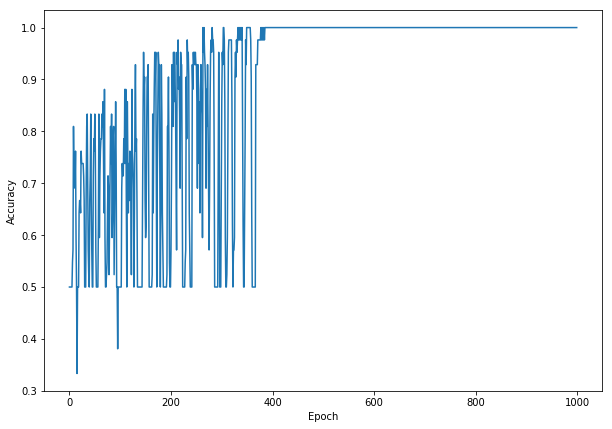

In [9]:
# Plot Accuracy graph
fig = plt.figure(figsize=(10,7))
plt.plot(accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

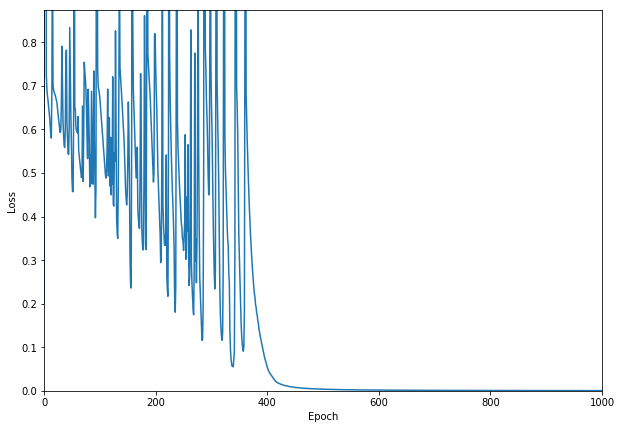

In [10]:
# Plot Loss graph
fig = plt.figure(figsize=(10,7))
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)/100])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Using the Model to make Prediction on Rock or Mine

In [11]:
# Reading the new dataset
def read_dataset():
    dir_path = "./MLData/00_Misc/"
    df = pd.read_csv(dir_path + "Sonar_new.csv")
    X_new = df[df.columns[0:60]].values
    y_new = df[df.columns[60]]

    # Encode the labels
    encoder = LabelEncoder()
    encoder.fit(y_new)
    y_new = encoder.transform(y_new)
    Y_new = one_hot_encode(y_new)
    return (X_new, Y_new)

# Define the encoder function
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_lables = len(np.unique(labels))
    encode = np.zeros((n_labels, n_unique_lables))
    encode[np.arange(n_labels), labels] = 1
    return encode

# Read the datset
X_new, Y_new = read_dataset()

In [12]:
X_new.shape, Y_new.shape

((15, 60), (15, 2))

In [13]:
saver.restore(sess, model_path)

prediction = tf.argmax(y, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("**************************************************************")
print("* 1 stands for M, (i.e. Mine) and 0 stands for R (i.e. Rock) *")
print("**************************************************************")
for i in range(1,15):
    prediction_run = sess.run(prediction, feed_dict={x:X_new[i].reshape(1,60)})
    accuracy_run = sess.run(accuracy, feed_dict={x:X_new[i].reshape(1,60), y_:Y_new[i].reshape(1,2)})
    print(i,"Original Class: ", int(sess.run(y_[i][1],feed_dict={y_:Y_new})), " Predicted Values: ", prediction_run[0] )
    print("Accuracy: ",str(accuracy_run*100)+"%")

INFO:tensorflow:Restoring parameters from ./TensorFlow/NMI/
**************************************************************
* 1 stands for M, (i.e. Mine) and 0 stands for R (i.e. Rock) *
**************************************************************
1 Original Class:  0  Predicted Values:  0
Accuracy:  100.0%
2 Original Class:  1  Predicted Values:  1
Accuracy:  100.0%
3 Original Class:  0  Predicted Values:  0
Accuracy:  100.0%
4 Original Class:  1  Predicted Values:  1
Accuracy:  100.0%
5 Original Class:  0  Predicted Values:  1
Accuracy:  0.0%
6 Original Class:  1  Predicted Values:  1
Accuracy:  100.0%
7 Original Class:  1  Predicted Values:  1
Accuracy:  100.0%
8 Original Class:  1  Predicted Values:  0
Accuracy:  0.0%
9 Original Class:  0  Predicted Values:  0
Accuracy:  100.0%
10 Original Class:  0  Predicted Values:  0
Accuracy:  100.0%
11 Original Class:  1  Predicted Values:  0
Accuracy:  0.0%
12 Original Class:  1  Predicted Values:  1
Accuracy:  100.0%
13 Original Class:  0 